# Kalman Filter Class Development

In [1]:
from __future__ import annotations

from abc import ABC, abstractmethod
from typing import Optional, Protocol

import numpy as np
from numpy.typing import NDArray

import matplotlib.pyplot as plt

# 1 - SystemModel

`SystemModel` defines the minimum interface a Kalman filter can rely on. Any model must
provide `Q(dt)` (process noise, n x n) and `R()` (measurement noise, m x m). These two form the
core contract required by all filters.

Specific filter types depend on additional model methods: LKF requires `F(dt)` and `H()`;
EKF requires `f`, `h`, and their Jacobians; UKF requires `f` and `h`. A model only needs to
implement the subset required by the filter being used.

The Protocol itself has no runtime logic—it simply formalizes the structure the filter
expects. Testing focuses on model implementations (valid and invalid) and on ensuring that
filters correctly consume these methods. This separation keeps the filter generic and lets
any well-formed model be plugged in without modifying the filter code.

In [2]:
class SystemModel(Protocol):
    """
    Contract for system models used by Kalman-type filters.
    LKF is Linear Kalman Filter
    EKF is Extended Kalman Filter
    UKF is Unscented Kalman Filter

    Every model MUST provide:
        Q(dt) : process noise covariance (n x n)
        R()   : measurement noise covariance (m x m)

    Additional methods required by specific filters:

    LKF:
        F(dt)       : state transition matrix (n x n)
        H()         : measurement/observation matrix     (m x n)

    EKF:
        f(x, u, dt)           : nonlinear state transition (n,)
        h(x)                  : nonlinear measurement model (m,)
        F_jacobian(x, u, dt)  : Jacobian of f wrt x (n x n)
        H_jacobian(x)         : Jacobian of h wrt x (m x n)

    UKF:
        f(x, u, dt)           : nonlinear state transition (n,)
        h(x)                  : nonlinear measurement model (m,)


    ---- REQUIRED BASE METHODS ----

    Q(dt):
        Input:
            dt: float
                Time step between k and k+1
        Output:
            ndarray (n x n)
                Process noise covariance evaluated for dt.

    R():
        Input: None
        Output:
            ndarray (m x m)
                Measurement noise covariance.

    A model may optionally implement the linear or nonlinear interfaces
    depending on which Kalman filter variant it will be used with.
    """

    def Q(self, dt: float) -> NDArray[np.float64]:
        ...

    def R(self) -> NDArray[np.float64]:
        ...

# 2 - BaseKalmanFilter

This base class defines the reusable structure shared by all Kalman filter
variants. It does not contain any filtering equations. The goal is to avoid
rewriting the same state storage, input validation, and predict/update calling
logic across LinearKF, EKF, and UKF.

The separation of responsibilities is intentional:

- The **SystemModel** defines the system’s behaviour: the state dynamics,
  the measurement relationship, and the noise covariances (Q and R).
  Different physical systems (e.g., spacecraft, vehicles, sensors) implement
  their own SystemModel.

- **BaseKalmanFilter** provides the common scaffold: it stores the state `x`
  and covariance `P`, exposes unified methods (`predict`, `update`, `step`),
  and enforces that subclasses supply the actual filtering mathematics.

- Each concrete filter (**LinearKF**, **EKF**, **UKF**) implements its own math
  inside `_predict_impl` and `_update_impl`, using the functions supplied by
  the model (e.g., F/H for linear systems or f/h for nonlinear systems).

As a result, the Kalman filter logic is cleanly separated from the system
dynamics. Any well-formed SystemModel can be paired with any Kalman filter
variant without modifying the filter code.


In [3]:
class BaseKalmanFilter(ABC):
    """
    Abstract base class for all Kalman filter variants.

    This class provides the common structure shared by LinearKF, EKF, and UKF:
      - storage for the current filtered state estimate (x) and covariance (P)
      - a reference to the system model, which supplies Q(dt), R(), and any
        additional functions required by the specific filter variant
      - the standard external interface: predict(), update(), and step()
      - input validation for initial state and covariance dimensions

    The class does *not* implement any Kalman filtering mathematics. Subclasses
    must implement the two internal methods:
        _predict_impl(u, dt)
        _update_impl(z)
    These methods perform the actual prediction and measurement-update steps
    using the model’s linear or nonlinear functions.

    Parameters
    ----------
    initial_state : ndarray (n,)
        Initial state estimate x_0.
    initial_covariance : ndarray (n, n)
        Initial covariance P_0.
    model : SystemModel
        Object implementing the SystemModel protocol. Must provide Q(dt), R(),
        and any additional methods required by the chosen filter variant.
    """

    def __init__(
        self,
        initial_state: NDArray[np.float64],
        initial_covariance: NDArray[np.float64],
        model: "SystemModel",
    ) -> None:

        # Store model reference
        self.model = model

        # Convert and validate shapes
        x0 = np.atleast_1d(np.asarray(initial_state, dtype=float))
        P0 = np.atleast_2d(np.asarray(initial_covariance, dtype=float))

        if x0.ndim != 1:
            raise ValueError("initial_state must be a 1D state vector.")
        if P0.shape[0] != P0.shape[1]:
            raise ValueError("initial_covariance must be square (n x n).")
        if P0.shape[0] != x0.shape[0]:
            raise ValueError(
                "Dimension mismatch: initial_covariance must match length "
                "of initial_state."
            )

        # Current filtered estimate x_hat_{k|k}, P_{k|k}
        self.x = x0.copy()
        self.P = P0.copy()
        self.n = len(x0)

        # Diagnostics from last cycle
        # Prediction (prior): x_hat_{k|k-1}, P_{k|k-1}
        self._last_x_pred = None
        self._last_P_pred = None

        # Innovation y_k and its covariance S_k
        self._last_innovation = None
        self._last_S = None

        # Kalman gain K_k
        self._last_gain = None

    # ------------------------------------------------------------------
    # External interface
    # ------------------------------------------------------------------

    def predict(
        self,
        u: Optional[NDArray[np.float64]] = None,
        dt: Optional[float] = None,
    ) -> None:
        """Run the prediction step."""
        self._predict_impl(u=u, dt=dt)

    def update(self, z: NDArray[np.float64]) -> None:
        """Run the measurement update step."""
        z = np.atleast_1d(np.asarray(z, dtype=float))
        self._update_impl(z=z)

    def step(
        self,
        z: NDArray[np.float64],
        u: Optional[NDArray[np.float64]] = None,
        dt: Optional[float] = None,
    ) -> None:
        """Convenience method: perform predict() followed by update()."""
        self.predict(u=u, dt=dt)
        self.update(z=z)

    # ------------------------------------------------------------------
    # Accessors (filtered)
    # ------------------------------------------------------------------

    @property
    def state(self) -> NDArray[np.float64]:
        """Return a copy of the current filtered state estimate x_hat_{k|k}."""
        return self.x.copy()

    @property
    def covariance(self) -> NDArray[np.float64]:
        """Return a copy of the current filtered covariance P_{k|k}."""
        return self.P.copy()

    # ------------------------------------------------------------------
    # Accessors (last prediction / diagnostics)
    # ------------------------------------------------------------------

    @property
    def last_predicted_state(self) -> Optional[NDArray[np.float64]]:
        """Return x_hat_{k|k-1} from the last predict() call, or None."""
        if self._last_x_pred is None:
            return None
        return self._last_x_pred.copy()

    @property
    def last_predicted_covariance(self) -> Optional[NDArray[np.float64]]:
        """Return P_{k|k-1} from the last predict() call, or None."""
        if self._last_P_pred is None:
            return None
        return self._last_P_pred.copy()

    @property
    def last_innovation(self) -> Optional[NDArray[np.float64]]:
        """Return the last innovation y_k = z_k - H x_hat_{k|k-1}, or None."""
        if self._last_innovation is None:
            return None
        return self._last_innovation.copy()

    @property
    def last_S(self) -> Optional[NDArray[np.float64]]:
        """Return the last innovation covariance S_k, or None."""
        if self._last_S is None:
            return None
        return self._last_S.copy()

    @property
    def last_gain(self) -> Optional[NDArray[np.float64]]:
        """Return the last Kalman gain K_k, or None."""
        if self._last_gain is None:
            return None
        return self._last_gain.copy()

    # ------------------------------------------------------------------
    # Named state access (for subclasses that define _state_index)
    # ------------------------------------------------------------------

    def get_estimate_of(self, name: str) -> float:
        """
        Return the current filtered estimate for a named state component,

            x_hat_{k|k}[name].

        Requires that the subclass has defined:
            self._state_index : dict[name -> index]
        """
        if self._state_index is None:
            raise AttributeError(
                "Named state access is not available; "
                "initialize the subclass with named states."
            )
        idx = self._state_index[name]
        return float(self.x[idx])

    def get_prediction_of(self, name: str) -> float:
        """
        Return the last predicted value for a named state component,

            x_hat_{k|k-1}[name].

        This is updated on each predict() call by the subclass.
        """
        if self._state_index is None:
            raise AttributeError(
                "Named state access is not available; "
                "initialize the subclass with named states."
            )
        if self._last_x_pred is None:
            raise RuntimeError(
                "No prediction stored yet. Call predict() at least once."
            )
        idx = self._state_index[name]
        return float(self._last_x_pred[idx])

    # ------------------------------------------------------------------
    # Subclass-required methods
    # ------------------------------------------------------------------

    @abstractmethod
    def _predict_impl(
        self,
        u: Optional[NDArray[np.float64]],
        dt: Optional[float],
    ) -> None:
        """
        Subclass-specific prediction logic.
        Must update self.x and self.P in-place.
        Should also update self._last_x_pred and self._last_P_pred.
        """
        pass

    @abstractmethod
    def _update_impl(self, z: NDArray[np.float64]) -> None:
        """
        Subclass-specific measurement update logic.
        Must update self.x and self.P in-place.
        May also update self._last_innovation, self._last_S, self._last_gain.
        """
        pass

    

# 3 - KalmanLogger

In [4]:
class KalmanLogger:
    """
    Generic logger for BaseKalmanFilter subclasses (LinearKF, EKF, UKF, ...).

    Usage:
        logger = KalmanLogger()

        for k, (t_k, z_k) in enumerate(data, start=1):
            kf.predict(dt=dt_k)
            kf.update(z_k)
            logger.log(kf, k=k, t=t_k, z=z_k)

        arrays = logger.as_arrays()
    """

    def __init__(self) -> None:
        # Meta
        self.k = []          # step index
        self.t = []          # timestamps
        self.z = []          # measurements

        # --- State & covariance ---
        self.x_pred = []     # x_{k|k-1}
        self.P_pred = []     # P_{k|k-1}
        self.x_est = []      # x_{k|k}
        self.P_est = []      # P_{k|k}

        # --- Diagnostics ---
        self.K = []          # Kalman gain
        self.innov = []      # innovation y_k
        self.S = []          # innovation covariance

    def log(
        self,
        kf: BaseKalmanFilter,
        k: int = None,
        t: float = None,
        z = None,
    ) -> None:
        """
        Log the current filter state AFTER update() is called.
        """

        # Meta
        self.k.append(k)
        self.t.append(t)
        self.z.append(None if z is None else np.asarray(z, dtype=float).copy())

        # --- States & Covariances ---
        x_pred = kf.last_predicted_state       # may be None at k=1
        P_pred = kf.last_predicted_covariance

        self.x_pred.append(None if x_pred is None else x_pred.copy())
        self.P_pred.append(None if P_pred is None else P_pred.copy())

        # Posterior estimate
        self.x_est.append(kf.state.copy())
        self.P_est.append(kf.covariance.copy())

        # --- Diagnostics ---
        K = kf.last_gain
        y = kf.last_innovation
        S = kf.last_S

        self.K.append(None if K is None else K.copy())
        self.innov.append(None if y is None else y.copy())
        self.S.append(None if S is None else S.copy())

    def as_arrays(self) -> dict:
        out = {}

        out["k"] = np.array(self.k, dtype=object)
        out["t"] = np.array(self.t, dtype=object)
        out["z"] = np.array(self.z, dtype=object)

        # Predictions may contain None (e.g. first step) → keep as object
        out["x_pred"] = np.array(self.x_pred, dtype=object)
        out["P_pred"] = np.array(self.P_pred, dtype=object)

        # Estimates are always valid → return stacked numeric arrays
        if self.x_est:
            out["x_est"] = np.stack(self.x_est).astype(float)   # (N, n)
            out["P_est"] = np.stack(self.P_est).astype(float)   # (N, n, n)
        else:
            out["x_est"] = np.empty((0, 0))
            out["P_est"] = np.empty((0, 0, 0))

        out["K"] = np.array(self.K, dtype=object)
        out["innov"] = np.array(self.innov, dtype=object)
        out["S"] = np.array(self.S, dtype=object)

        return out


# 4 - Linear Kalman Filter

## 4.1 - LinearGaussianModel

In [5]:
class LinearGaussianModel:
    """
    Concrete SystemModel implementation for linear-Gaussian systems with
    constant matrices F, H, Q, R (and optional G).

        x_{k+1} = F x_k + G u_k + w_k
        z_k     = H x_k + v_k

    F, H, Q, R are constant; dt is ignored in this simple model.
    """

    def __init__(self, F, H, Q, R, G=None) -> None:
        self.F_mat = np.asarray(F, dtype=float)
        self.H_mat = np.asarray(H, dtype=float)
        self.Q_mat = np.asarray(Q, dtype=float)
        self.R_mat = np.asarray(R, dtype=float)
        self.G_mat = None if G is None else np.asarray(G, dtype=float)

        n = self.F_mat.shape[0]
        if self.F_mat.shape != (n, n):
            raise ValueError("F must be square (n x n).")
        if self.Q_mat.shape != (n, n):
            raise ValueError("Q must be square (n x n).")
        if self.H_mat.shape[1] != n:
            raise ValueError("H must have n columns matching F.")
        m = self.H_mat.shape[0]
        if self.R_mat.shape != (m, m):
            raise ValueError("R must be square (m x m).")
        if self.G_mat is not None and self.G_mat.shape[0] != n:
            raise ValueError("G must have same row count as F.")

    # ---- SystemModel interface (linear part) ----

    def F(self, dt: float) -> NDArray[np.float64]:
        return self.F_mat

    def H(self) -> NDArray[np.float64]:
        return self.H_mat

    def Q(self, dt: float) -> NDArray[np.float64]:
        return self.Q_mat

    def R(self) -> NDArray[np.float64]:
        return self.R_mat

    def G(self, dt: float) -> NDArray[np.float64]:
        if self.G_mat is None:
            raise AttributeError("This model does not define a control matrix G.")
        return self.G_mat

## 4.2 - LinearKF

In [6]:
class LinearKF(BaseKalmanFilter):
    """
    Linear Kalman Filter for time-varying linear-Gaussian systems.

    Initialization
    --------------
        kf = LinearKF(states, initial_covariance, model, ...)

    where
        states:
            - dict{name -> value}  (named, ordered states), or
            - 1D ndarray           (anonymous state vector)

        initial_covariance:
            - 2D ndarray (n x n): full P0, or
            - 1D ndarray (n,): diag(P0), or
            - scalar: sigma2 * I, or
            - dict{name -> var}: diag(P0) per named state

        model:
            - SystemModel object with F(dt), H(), Q(dt), R(), optional G(dt)
          OR
        F, H, Q, R (and optional G) matrices provided via keyword arguments.
    """

    def __init__(
        self,
        states,
        initial_covariance,
        model: Optional[SystemModel] = None,
        *,
        F: Optional[NDArray[np.float64]] = None,
        H: Optional[NDArray[np.float64]] = None,
        Q: Optional[NDArray[np.float64]] = None,
        R: Optional[NDArray[np.float64]] = None,
        G: Optional[NDArray[np.float64]] = None,
    ) -> None:

        # 1) Build initial_state from states
        if isinstance(states, dict):
            # assume insertion order is intended state ordering
            self._state_names = list(states.keys())
            self._state_index = {
                name: i for i, name in enumerate(self._state_names)
            }
            x0 = np.array([states[name] for name in self._state_names], dtype=float)
        else:
            self._state_names = None
            self._state_index = None
            x0 = np.atleast_1d(np.asarray(states, dtype=float))

        n = x0.size

        # 2) Decide / build SystemModel
        matrices_given = all(m is not None for m in (F, H, Q, R))

        if model is None and not matrices_given:
            raise ValueError(
                "Either provide a 'model' (SystemModel) or the matrices F, H, Q, R."
            )
        if model is not None and matrices_given:
            raise ValueError(
                "Provide either 'model' or matrices (F, H, Q, R), not both."
            )

        if model is None:
            # Wrap constant matrices into a linear SystemModel
            model = LinearGaussianModel(F=F, H=H, Q=Q, R=R, G=G)

        # 3) Build initial covariance P0
        if isinstance(initial_covariance, dict):
            if self._state_names is None:
                raise ValueError(
                    "Dict initial_covariance requires named states (dict) input."
                )

            # Ensure every state has an explicit variance
            missing = [name for name in self._state_names
                    if name not in initial_covariance]
            if missing:
                raise ValueError(
                    "initial_covariance dict is missing variance entries for "
                    f"state(s): {missing}"
                )

            P0 = np.zeros((n, n), dtype=float)
            for i, name in enumerate(self._state_names):
                P0[i, i] = float(initial_covariance[name])

        else:
            P0_arr = np.asarray(initial_covariance, dtype=float)
            if P0_arr.ndim == 0:
                P0 = np.eye(n) * float(P0_arr)
            elif P0_arr.ndim == 1:
                if P0_arr.size != n:
                    raise ValueError(
                        f"1D initial_covariance must have length {n}, "
                        f"got {P0_arr.size}."
                    )
                P0 = np.diag(P0_arr)
            elif P0_arr.ndim == 2:
                if P0_arr.shape != (n, n):
                    raise ValueError(
                        f"2D initial_covariance must be ({n},{n}), "
                        f"got {P0_arr.shape}."
                    )
                P0 = P0_arr
            else:
                raise ValueError(
                    "initial_covariance must be scalar, 1D (diag), 2D (full), "
                    "or dict{name -> var}."
                )


        # 4) Call base constructor
        super().__init__(
            initial_state=x0,
            initial_covariance=P0,
            model=model,
        )

    # ------------------------------------------------------------------
    # Internal predict / update implementations
    # ------------------------------------------------------------------

    def _predict_impl(
        self,
        u: Optional[NDArray[np.float64]],
        dt: Optional[float],
    ) -> None:
        if dt is None:
            raise ValueError("LinearKF.predict() requires a time step dt.")

        F = self.model.F(dt)
        Q = self.model.Q(dt)

        x_pred = F @ self.x

        if u is not None:
            if not hasattr(self.model, "G"):
                raise AttributeError(
                    "Control input u was provided, but model does not define G(dt)."
                )
            G = self.model.G(dt)
            u = np.atleast_1d(np.asarray(u, dtype=float))
            x_pred = x_pred + G @ u

        P_pred = F @ self.P @ F.T + Q

        # Diagnostics: prior
        self._last_x_pred = x_pred.copy()
        self._last_P_pred = P_pred.copy()

        self.x = x_pred
        self.P = P_pred

    def _update_impl(self, z: NDArray[np.float64]) -> None:
        H = self.model.H()
        R = self.model.R()

        y = z - H @ self.x
        S = H @ self.P @ H.T + R
        K = np.linalg.solve(S.T, (H @ self.P).T).T 


        x_upd = self.x + K @ y

        I = np.eye(self.n)
        I_minus_KH = I - K @ H
        P_upd = I_minus_KH @ self.P @ I_minus_KH.T + K @ R @ K.T

        self.x = x_upd
        self.P = P_upd

        # Diagnostics: update
        self._last_innovation = y
        self._last_S = S
        self._last_gain = K


## 4.3 - Example

### 4.3.1 - 1D Linear Kalman Filter Example

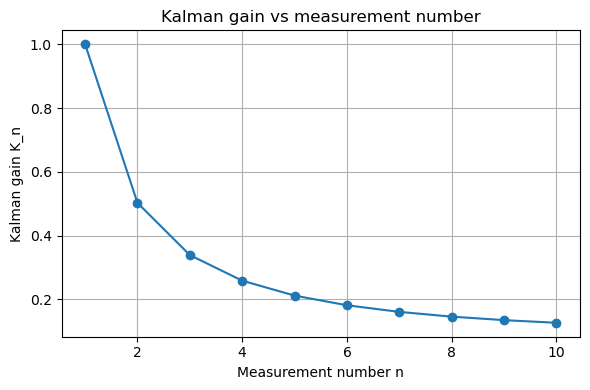

In [7]:
# 1D constant-temperature model matching Becker Example 6
# ------------------------------------------------------------
# Step 1: Define state (names + initial values)
# ------------------------------------------------------------

# Single state: temperature T
initial_states = {"T": 60.0}   # very wrong initial guess on purpose

# Initial covariance: huge uncertainty on T
initial_covariance = {"T": 100.0**2}


# ------------------------------------------------------------
# Step 2: Define model (LinearGaussianModel with F, H, Q, R)
# ------------------------------------------------------------

# True temperature values at measurement times (for reference only)
true_temps = np.array([
    50.005, 49.994, 49.993, 50.001, 50.006,
    49.998, 50.021, 50.005, 50.000, 49.997
])

# Measured temperatures
measurements = np.array([
    49.986, 49.963, 50.090, 50.001, 50.018,
    50.050, 49.938, 49.858, 49.965, 50.114
])

n_meas = len(measurements)
indices = np.arange(1, n_meas + 1)  # 1..N


# Kalman filter parameters from Becker Example 6
q = 1.0e-4        # process noise variance
sigma_r = 0.1     # measurement std dev
r = sigma_r**2    # measurement variance

# For 1D constant temperature:
#   x_{k+1} = x_k + w_k
#   z_k     = x_k + v_k
F = np.array([[1.0]])
H = np.array([[1.0]])
Q = np.array([[q]])
R = np.array([[r]])

# Build a linear-Gaussian SystemModel instance
const_temp_model = LinearGaussianModel(F=F, H=H, Q=Q, R=R)


# ------------------------------------------------------------
# Step 3: Run Kalman filter
# ------------------------------------------------------------

kf = LinearKF(
    states=initial_states,
    initial_covariance=initial_covariance,
    model=const_temp_model,
)

logger = KalmanLogger()

dt = 5.0  # seconds between measurements (not used by this model)

for k, z in enumerate(measurements, start=1):
    kf.predict(dt=dt)
    kf.update(np.array([z]))
    logger.log(kf, k=k, t=k * dt, z=z)

arrays = logger.as_arrays()

# ------------------------------------------------------------
# Step 4: Analyse results
# ------------------------------------------------------------

# Extract estimated temperature (posterior x_est) and covariance P_est
x_est_mat = np.stack(arrays["x_est"])     # shape: (N, 1)
P_est_mat = np.stack(arrays["P_est"])     # shape: (N, 1, 1)

estimates = x_est_mat[:, 0]              # (N,)
sigmas = np.sqrt(P_est_mat[:, 0, 0])     # (N,)

ci_upper = estimates + 1.96 * sigmas
ci_lower = estimates - 1.96 * sigmas

# Extract Kalman gains
K_list = arrays["K"]
gains = np.array([K[0, 0] for K in K_list])

# Example: plot Kalman gain vs measurement number
plt.figure(figsize=(6, 4))
plt.plot(indices, gains, marker="o")
plt.xlabel("Measurement number n")
plt.ylabel("Kalman gain K_n")
plt.title("Kalman gain vs measurement number")
plt.grid(True)
plt.tight_layout()
plt.show()

# You can similarly plot:
# - estimates vs true_temps
# - confidence intervals vs measurements

### 4.3.2 - Multivariate Linear Kalman Filter Example

# 5 - EKF

# 6 - UKF